# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

## 2. Pre-processing

**Observation:**

| # | Observation                                                                                                                                                                                            | Recommended Next Steps                                                                                                                                                                                                                                                          |
|:-:|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1 | **Fix missing, invalid, duplicated values :** Fix missing, invalid, or inconsistent values  | Finding the best way to replace missing, invalid, or inconsistent data while guaranteeing the quality of the dataset.  |
| 2 | **Invalid Amenity Values:** The amenity features (e.g., `MaintenanceStaff`, `Gymnasium`) are expected to be binary (0 or 1), but the plots show values greater than 1. This indicates a data quality issue. | **Clean and Standardize Data:** 1. Investigate the unique values in these columns (e.g., `df['MaintenanceStaff'].unique()`). 2. Define a rule to correct them (e.g., map all non-zero values to 1). 3. Apply the correction and then re-visualize with a `countplot` to confirm the data is now binary. |

### 2.1 Loading the dataset

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('../../src/utils')

# Utilities
from housing_prices_column_definition import Column

sourceDataset = '../../datasets/processed/housing_prices/hyderabad_house_price_original.parquet'
targetDataset = '../../datasets/processed/housing_prices/hyderabad_house_price_cleanup.parquet'

dataset = pd.read_parquet(sourceDataset)

### 2.2 Checking for Missing Data

**Problem:**

The dataset may contains missing values in several columns, particularly in features like Bedrooms, Bathrooms, Balcony, and Parking. This is common in real estate data due to variations in data entry or properties lacking certain features.

**Justification:** 

Leaving missing values unaddressed will cause errors when training a machine learning model and can lead to an inaccurate and unreliable price prediction model. Correctly handling them is essential for building a robust model that can make accurate predictions on new data.

**Action:** 
- Quantify: First, calculate the percentage of missing values for each column to understand the extent of the issue.
- Impute Numerical Features: For columns like Bedrooms and Bathrooms, fill missing values using the median, as it is less sensitive to outlier prices for luxury or very small properties.
- Impute Categorical/Discrete Features: For features like Parking or Balcony, fill missing values with the mode (the most common value), as this likely represents the typical property configuration.

**Verify:**

After imputation, confirm that no missing values remain in the dataset.

In [2]:
total_missing_values = dataset.isnull().sum().sum()

print(f"There are {total_missing_values} missing values.")

if total_missing_values > 0:
    raise NotImplementedError("The logic to handle missing values has not been implemented yet.")

dataset.isnull().sum()

There are 0 missing values.


Price                  0
Area                   0
Location               0
No. of Bedrooms        0
Resale                 0
MaintenanceStaff       0
Gymnasium              0
SwimmingPool           0
LandscapedGardens      0
JoggingTrack           0
RainWaterHarvesting    0
IndoorGames            0
ShoppingMall           0
Intercom               0
SportsFacility         0
ATM                    0
ClubHouse              0
School                 0
24X7Security           0
PowerBackup            0
CarParking             0
StaffQuarter           0
Cafeteria              0
MultipurposeRoom       0
Hospital               0
WashingMachine         0
Gasconnection          0
AC                     0
Wifi                   0
Children'splayarea     0
LiftAvailable          0
BED                    0
VaastuCompliant        0
Microwave              0
GolfCourse             0
TV                     0
DiningTable            0
Sofa                   0
Wardrobe               0
Refrigerator           0


### 2.3 Checking for Negative Values

**Problem:**

The dataset may contain negative values in numerical columns where they are logically impossible, such as Area, Price, Bedrooms, or Bathrooms. These represent clear data entry errors or corruption.

**Justification:**

Negative values for physical attributes are nonsensical and invalid. If not removed, they will distort statistical calculations (like the mean or minimum), skew data visualizations, and severely degrade the performance and reliability of the price prediction model. The model would be learning from impossible data points.

**Action:**
- Identify: Isolate all numerical columns in the dataset.
- Detect: For each numerical column, filter and count the number of entries that are less than zero.
- Remove: Eliminate any rows that contain these invalid negative values. Since these are errors and not genuine data, removal is the most appropriate action to maintain the integrity of the dataset.

**Verify:**

After the removal step, re-run the check on all numerical columns to confirm that no negative values remain and that the minimum value for each of these features is now zero or greater.

In [3]:
negative_values = dataset[(dataset[[Column.PRICE.name, Column.AREA.name, Column.NO_OF_BEDROOMS.name]] < 0).any(axis=1)]
total_negative_values = negative_values.isnull().sum().sum()

print(f"There are {total_negative_values} negatives values.")

if total_negative_values > 0:
    raise NotImplementedError("The logic to handle negative values has not been implemented yet.")

dataset.isnull().sum()

There are 0 negatives values.


Price                  0
Area                   0
Location               0
No. of Bedrooms        0
Resale                 0
MaintenanceStaff       0
Gymnasium              0
SwimmingPool           0
LandscapedGardens      0
JoggingTrack           0
RainWaterHarvesting    0
IndoorGames            0
ShoppingMall           0
Intercom               0
SportsFacility         0
ATM                    0
ClubHouse              0
School                 0
24X7Security           0
PowerBackup            0
CarParking             0
StaffQuarter           0
Cafeteria              0
MultipurposeRoom       0
Hospital               0
WashingMachine         0
Gasconnection          0
AC                     0
Wifi                   0
Children'splayarea     0
LiftAvailable          0
BED                    0
VaastuCompliant        0
Microwave              0
GolfCourse             0
TV                     0
DiningTable            0
Sofa                   0
Wardrobe               0
Refrigerator           0


### 2.4 Detecting and Removing Duplicate Samples

**Problem:**

The dataset might contain duplicate rows, which are entire samples (properties) that have the exact same values across all features. This often happens due to errors during data collection or merging different datasets.

**Justification:**

Duplicate samples add no new information and can artificially inflate the influence of certain data points. This introduces a bias into the model, potentially leading it to perform poorly on new, unseen data. Removing them is crucial for building a clean and reliable dataset.

**Action:**

- Detect: First, identify and count the number of duplicate rows in the dataset. In Python with pandas, you can use df.duplicated().sum().
- Eliminate: Remove these duplicate rows. The command df.drop_duplicates(inplace=True) is typically used to delete them directly from your dataset.

**Verify:**

After running the removal command, re-run the detection step (df.duplicated().sum()). The expected result should be 0, confirming that all duplicate samples have been successfully eliminated.

In [4]:
total_duplicates_samples = dataset.duplicated().sum()

print(f"There are {total_duplicates_samples} duplicates samples before pre-processing.")

if total_duplicates_samples > 0:
    dataset = dataset.drop_duplicates()

print(f"There are {dataset.duplicated().sum()} duplicates samples after pre-processing.")
print(f"Total samples: {dataset.shape[0]} after pre-processing.")

There are 520 duplicates samples before pre-processing.
There are 0 duplicates samples after pre-processing.
Total samples: 1998 after pre-processing.


### 2.5  Handling Inconsistent Values in Amenity Columns

**Problem:**

The EDA revealed that multiple binary columns representing amenities (e.g., Gymnasium, SwimmingPool, MaintenanceStaff) contain the value 9, which is inconsistent with the expected binary format of 0 or 1.

**Justification:**

The value 9 is a common placeholder for missing or unknown information. Leaving it in would cause the model to treat it as a third, distinct category, which is incorrect. 

**Action:**

We'll treat these values ​​as missing data. The most robust strategy is to eliminate them, since we're not sure what the value 9 represents, and the samples involved are few.

**Verify:**

After performing the removal, re-examine the unique values for each of the corrected amenity columns. The output should confirm that the value 9 has been successfully eliminated and the only values present in these columns are now 0 and 1. This ensures the data is consistent and ready for modeling.

In [5]:
df = dataset.copy()  
df = df.select_dtypes(include=["int64", "float64"]).drop(columns=[Column.PRICE.name, Column.AREA.name, Column.NO_OF_BEDROOMS.name])

columns = df.columns.tolist()
affected_examples = (df[columns] == 9).any(axis=1)

# Remove invalid samples
dataset = dataset[~affected_examples]

display(Markdown('** Verify: **')) 
print(f"Samples with invalid value before remove them: {affected_examples.sum()}")
print(f"Samples with invalid value after remove them  {(dataset[columns] == 9).any(axis=1).sum()}")


dataset.to_parquet(targetDataset)

** Verify: **

Samples with invalid value before remove them: 84
Samples with invalid value after remove them  0


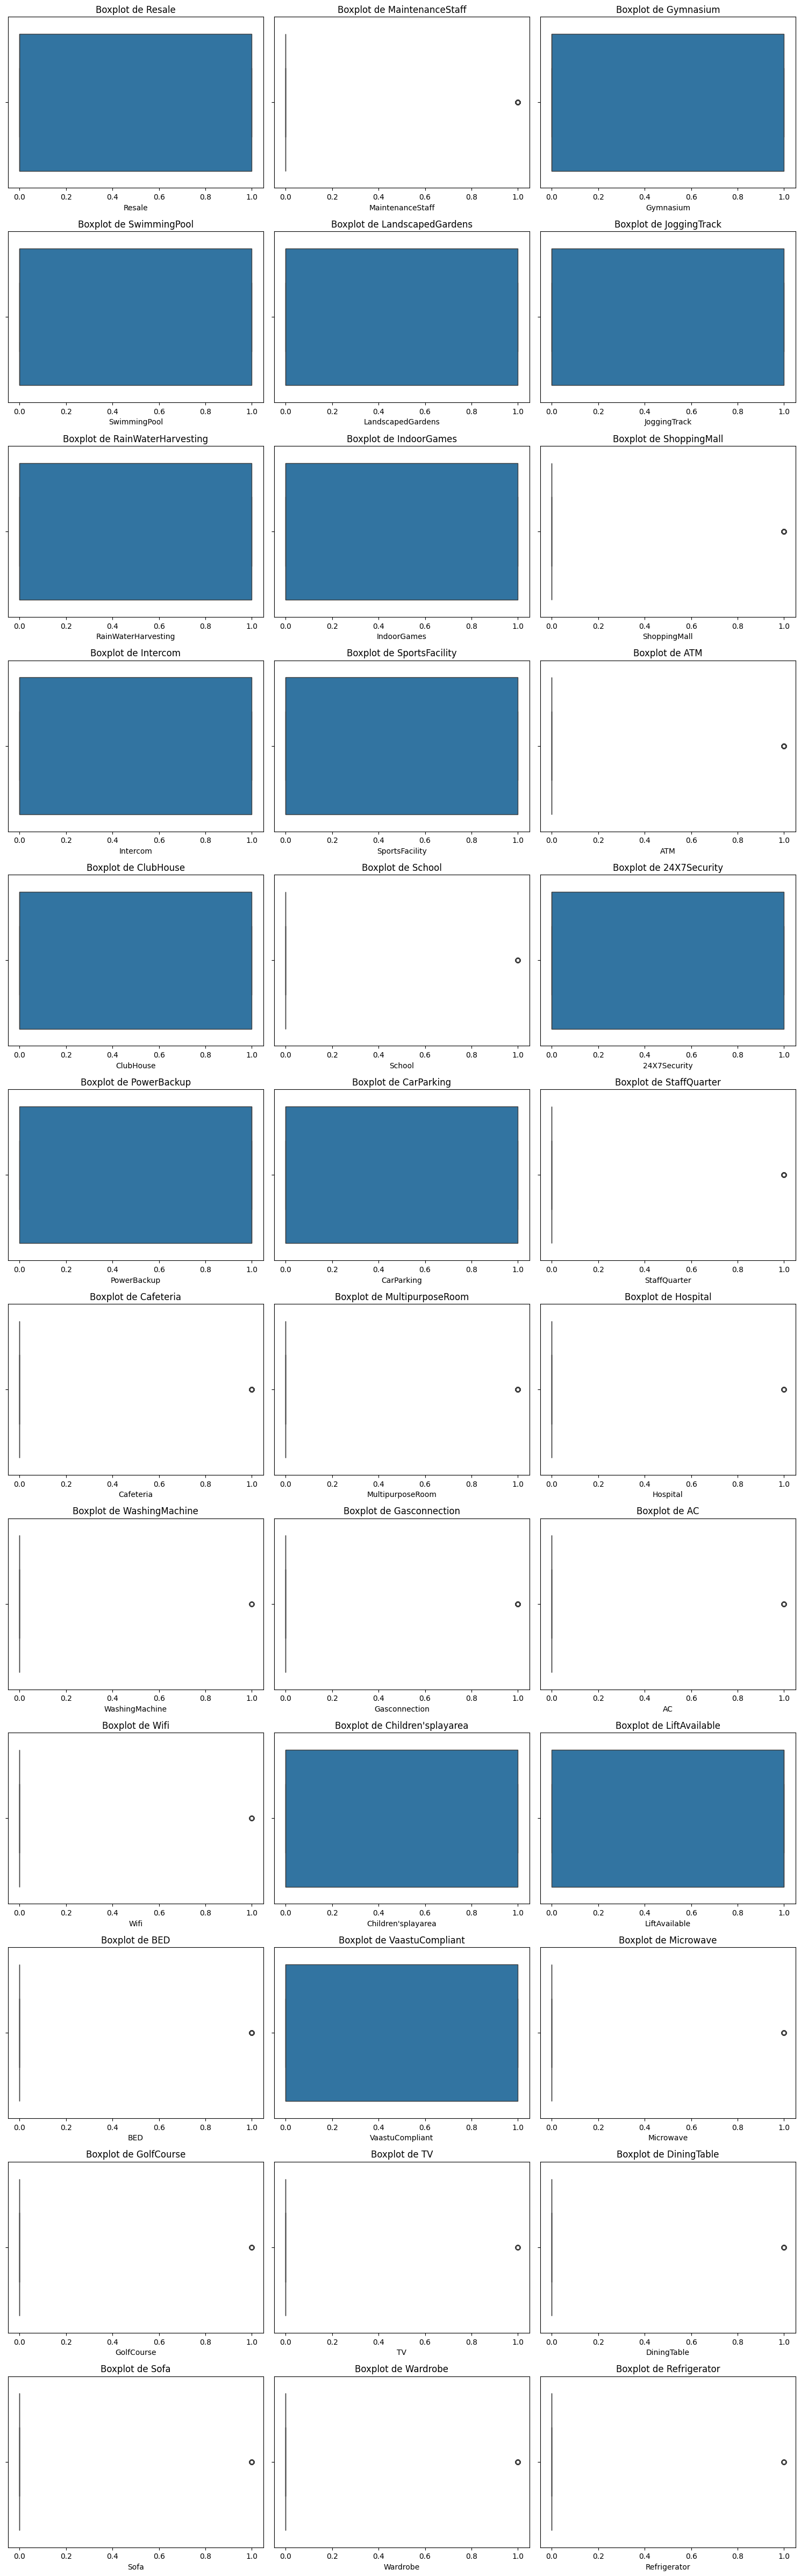

In [6]:
numeric_cols = dataset.copy().drop(columns=[Column.PRICE.name, Column.AREA.name, Column.NO_OF_BEDROOMS.name]).select_dtypes(include=["int64", "float64"]).columns

n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()


for i, col in enumerate(numeric_cols):
    sns.boxplot(x=dataset[col], ax=axes[i])
    
    axes[i].set_title(f"Boxplot de {col}")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()